In [446]:
%load_ext autoreload
%autoreload 2

# System imports
from dataclasses import dataclass
from typing import NamedTuple, Callable, Optional
import time

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi
import optax

# Local imports
import loss
import dataset
from model import VGAEOutput
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX version: 0.3.13
Numpyro version: 0.9.2


In [447]:
RNG_KEY = jax.random.PRNGKey(42)

In [448]:
IMAGE_SHAPE = (15, 10)

(
    A, D, d, 
    num_regions, 
    (num_x, num_y),
) = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

np.linalg.det(np.linalg.inv(D - A))

0.0

In [449]:
from typing import Dict

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  decoder_params: Optional[Params] = None
  
CAR_ARGS = CARArgs()

In [450]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  # alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.99))

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

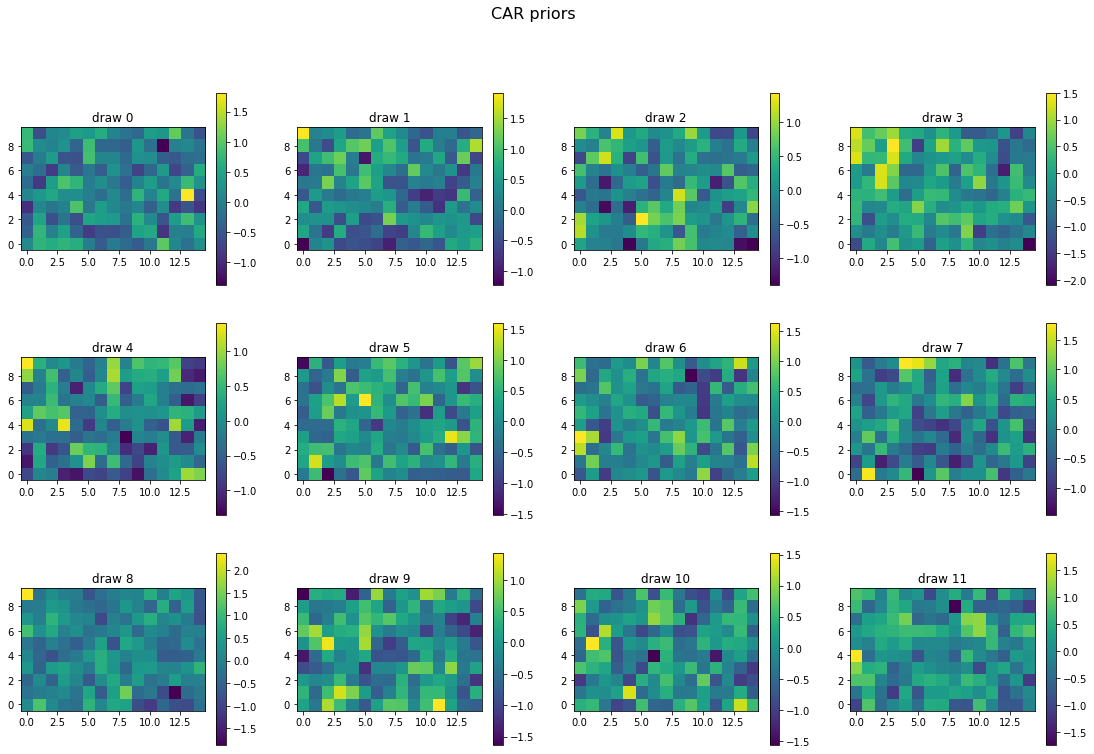

In [451]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_preds = Predictive(car_predictive_model, num_samples=12)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

plotting.plot_samples(car_draws, image_shape=IMAGE_SHAPE)

In [452]:
def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car']  # (batch_size, num_regions)
    return car_draws

# Training VAE

In [453]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun = loss.compute_mse_loss
  
  batch_size: int = 100
  
  hidden_dim: int = 130
  latent_dim: int = 130
  output_dim: int = A.shape[0]
  
  beta: float = 1.0
  learning_rate: float = 1e-3
  epochs: int = 10_000
  
  eval_frequency: int = 10
  
ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


In [454]:
from pathlib import Path
train_path = Path.cwd() / 'dataset.nosync/synthetic_car_train_data_ALPHA_0.4_0.99_v2.npy'
val_path = Path.cwd() / 'dataset.nosync/synthetic_car_val_data_ALPHA_0.4_0.99_v2.npy'
# train_path = Path.cwd() / 'dataset.nosync/synthetic_car_train_data_FixedAlpha0.5.npy'
# val_path = Path.cwd() / 'dataset.nosync/synthetic_car_val_data_FixedAlpha0.5.npy'
# train_path = Path.cwd() / 'dataset.nosync/synthetic_car_train_data_WIDERALPHA.npy'
# val_path = Path.cwd() / 'dataset.nosync/synthetic_car_val_data_WIDERALPHA.npy'

OVERRIDE_SAVE = False

RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)
if (train_path.exists() and val_path.exists()) and not OVERRIDE_SAVE:
    train_data = jnp.array(np.load(train_path))
    val_data = jnp.array(np.load(val_path))
else:
    train_data = generate_car_batch(train_rng, batch_size=1_000_000)
    val_data = generate_car_batch(val_rng, batch_size=1_000_000)
    np.save(train_path, np.asarray(train_data))
    np.save(val_path, np.asarray(val_data))

In [455]:
from pathlib import Path
train_path_2 = Path.cwd() / 'dataset.nosync/synthetic_car_train_data_WIDERALPHA.npy'
val_path_2 = Path.cwd() / 'dataset.nosync/synthetic_car_val_data_WIDERALPHA.npy'

OVERRIDE_SAVE = False

RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)
if (train_path_2.exists() and val_path_2.exists()) and not OVERRIDE_SAVE:
    train_data_2 = jnp.array(np.load(train_path_2))
    val_data_2 = jnp.array(np.load(val_path_2))
else:
    train_data_2 = generate_car_batch(train_rng, batch_size=1_000_000)
    val_data_2 = generate_car_batch(val_rng, batch_size=1_000_000)
    np.save(train_path_2, np.asarray(train_data_2))
    np.save(val_path_2, np.asarray(val_data_2))

In [456]:
train_data = jnp.concatenate((train_data, train_data_2, val_data_2), axis=0)
train_data.shape

(2000000, 150)

In [457]:
batched_train_data = jnp.reshape(train_data, (-1, ARGS.batch_size, num_regions))
batched_val_data = jnp.reshape(val_data, (-1, ARGS.batch_size, num_regions))

In [458]:
assert not np.isnan(train_data).any()
assert not np.isnan(val_data).any()

In [459]:
# batched_train_data = jnp.concatenate([batched_train_data, batched_val_data[:-1001]], axis=0)
# batched_val_data = batched_val_data[-1001:]

print(batched_train_data.shape)
print(batched_val_data.shape)

(20000, 100, 150)
(10000, 100, 150)


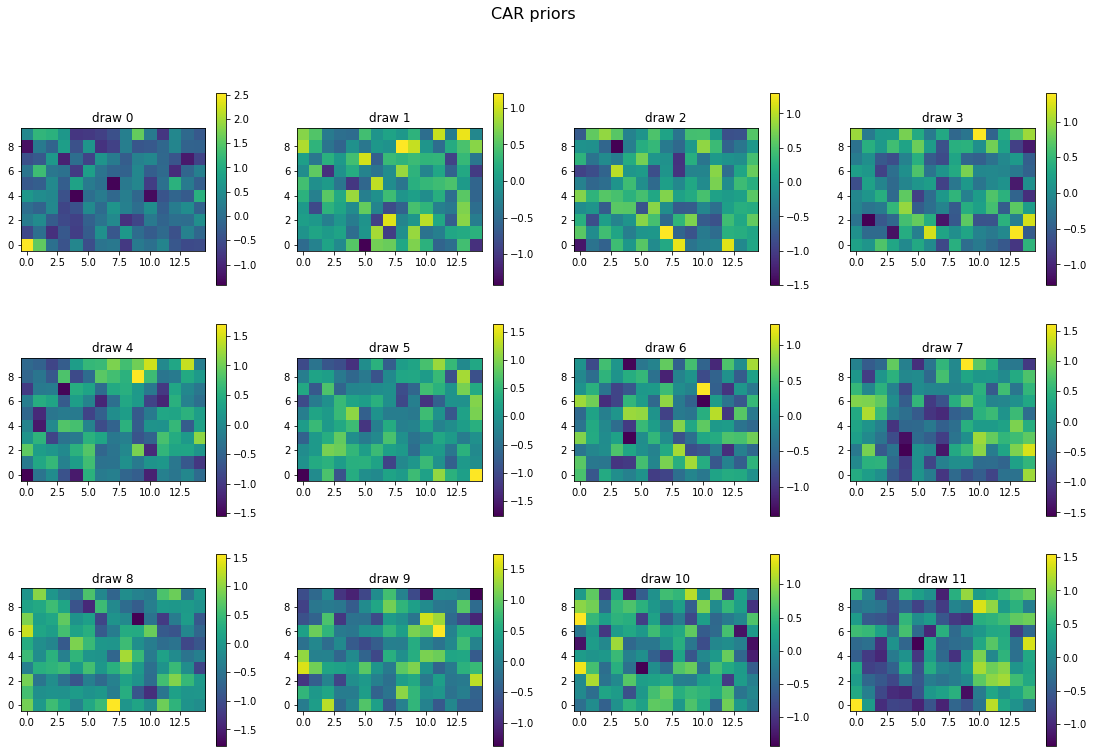

In [460]:
iii = jax.random.choice(jax.random.PRNGKey(4), len(batched_train_data))
plotting.plot_samples(batched_train_data[iii], image_shape=IMAGE_SHAPE)

## PriorVAE model

In [461]:
from typing import Tuple

ACT_FN = jax.nn.elu

def priorvae_encoder(
        x: jnp.ndarray,
        hidden_dim: int,
        latent_dim: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Encoder for PriorVAE."""
    x = hk.Flatten()(x)
    x = hk.Sequential(
        [
            hk.Linear(hidden_dim),
            ACT_FN,
        ]
    )(x)
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def priorvae_decoder(
        z: jnp.ndarray,
        hidden_dim: int,
        output_dim: int) -> jraph.GraphsTuple:
    output = hk.Sequential(
        [
            hk.Linear(hidden_dim, name='decoder_hidden'),
            ACT_FN,
            hk.Linear(output_dim, name='output'),
        ]
    )(z)
    output = jnp.reshape(output, (-1, output_dim))
    return output


class PriorVAE(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    def __init__(
        self,
        hidden_dim: int,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, x: jnp.ndarray) -> VGAEOutput:
        # x = x.astype(jnp.float32)
        mean, log_std = priorvae_encoder(
            x,
            self._hidden_dim,
            self._latent_dim,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = priorvae_decoder(
            z,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, std, output)

In [462]:
net = hk.transform(
  lambda x: PriorVAE(
    hidden_dim=ARGS.hidden_dim,
    latent_dim=ARGS.latent_dim, 
    output_dim=ARGS.output_dim)(x))

In [463]:
# optimizer = optax.adam(learning_rate=ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=1000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

In [464]:
def compute_mse_2(x, y):
    return jnp.mean(jnp.square(x - y), axis=-1)

In [465]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    batch: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  # log_likelihood_loss_fn = ARGS.loss_fn
  log_likelihood_loss_fn = compute_mse_2
  
  outputs: VGAEOutput = net.apply(params, rng_key, batch)
  
  log_likelihood = -log_likelihood_loss_fn(outputs.output, batch)
  kld = loss.compute_kl_gaussian(outputs.mean, outputs.log_std)
  elbo = 0.001*log_likelihood - ARGS.beta*kld
  
  return -jnp.mean(elbo), kld.mean()
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    batch: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [466]:
# Initialize net with an arbitrary graph
RNG_KEY, rng_init, rng_params = jax.random.split(RNG_KEY, 3)

init_batch = batched_train_data[0]
params = net.init(rng_params, init_batch)
opt_state = optimizer.init(params)

In [467]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

train_size = len(batched_train_data)
val_size = len(batched_val_data)

eval_counter: int = 0

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):   
  update_rng = jax.random.fold_in(train_rng, epoch)
  
  train_batch = batched_train_data[epoch % train_size]
  # generate_rng1, generate_rng2 = jax.random.split(update_rng)
  # train_batch = generate_car_batch(generate_rng1, batch_size=ARGS.batch_size)
  
  params, opt_state = update(params, update_rng, opt_state, train_batch)
  
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng, _ = jax.random.split(evaluate_rng, 3)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_batch)
    
    val_batch = batched_val_data[eval_counter]
    # val_batch = generate_car_batch(generate_rng2, batch_size=ARGS.batch_size)
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_klds.append(train_kld)
    val_klds.append(val_kld)
    
    if jnp.isnan(train_loss) or jnp.isnan(val_loss):
      train_losses = train_losses[:-1]
      val_losses = val_losses[:-1]
      assert False, 'Train or val loss is nan'
    
    eval_counter += 1

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x168725ca0>
12:45:06 STEP: 0; Train loss: 289.851; Validation loss: 471.057
12:45:06 STEP: 10; Train loss: 241.904; Validation loss: 263.565
12:45:06 STEP: 20; Train loss: 180.291; Validation loss: 171.766
12:45:06 STEP: 30; Train loss: 129.986; Validation loss: 132.432
12:45:06 STEP: 40; Train loss: 102.559; Validation loss: 103.047
12:45:06 STEP: 50; Train loss: 79.876; Validation loss: 76.528
12:45:06 STEP: 60; Train loss: 57.625; Validation loss: 58.760
12:45:06 STEP: 70; Train loss: 41.755; Validation loss: 42.617
12:45:06 STEP: 80; Train loss: 31.150; Validation loss: 30.288
12:45:06 STEP: 90; Train loss: 20.109; Validation loss: 20.900
12:45:06 STEP: 100; Train loss: 13.755; Validation loss: 13.840
12:45:06 STEP: 110; Train loss: 9.264; Validation loss: 9.556
12:45:06 STEP: 120; Train loss: 5.750; Validation loss: 6.374
12:45:06 STEP: 130; Train loss: 3.680; Validation loss: 3.738
12:45:06 STEP: 140; Train loss: 2.210; Validation loss: 2.29

In [468]:
print(eval_counter)

1001


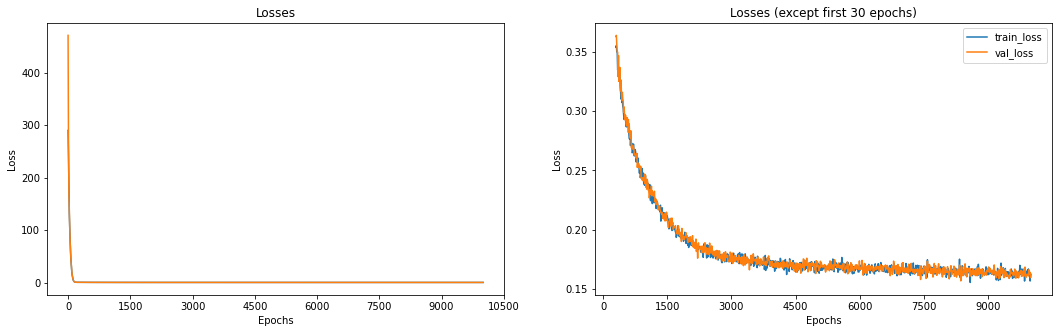

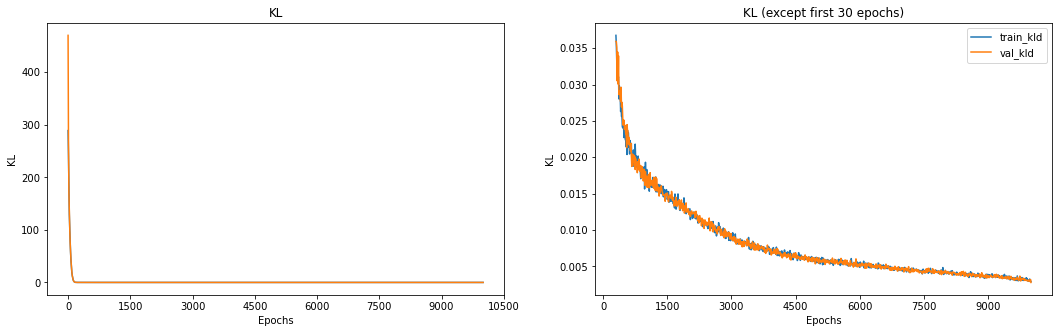

In [469]:
from matplotlib.ticker import MaxNLocator

xs = np.arange(len(train_losses))*ARGS.eval_frequency

_, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].plot(xs, train_losses, label='train_loss')
ax[0].plot(xs, val_losses, label='val_loss')

ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].plot(xs[30:], train_losses[30:], label='train_loss')
ax[1].plot(xs[30:], val_losses[30:], label='val_loss')

for i in range(2):
    ax[i].set_ylabel('Loss')
    ax[i].set_xlabel('Epochs')
    
ax[0].set_title('Losses')
ax[1].set_title('Losses (except first 30 epochs)')

plt.legend()
plt.show()

# KLD
_, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].plot(xs, train_klds, label='train_kld')
ax[0].plot(xs, val_klds, label='val_kld')

ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].plot(xs[30:], train_klds[30:], label='train_kld')
ax[1].plot(xs[30:], val_klds[30:], label='val_kld')

for i in range(2):
    ax[i].set_ylabel('KL')
    ax[i].set_xlabel('Epochs')
    
ax[0].set_title('KL')
ax[1].set_title('KL (except first 30 epochs)')

plt.legend()
plt.show()

In [470]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


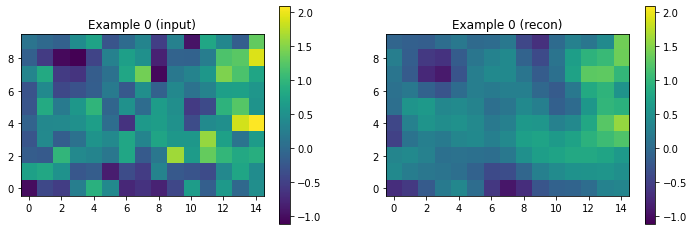

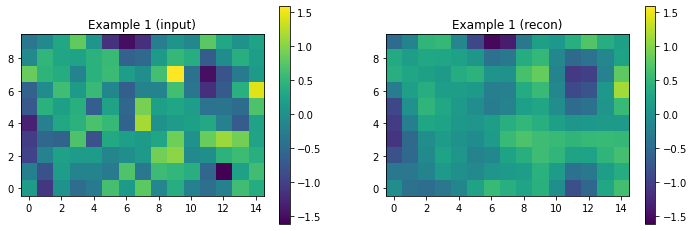

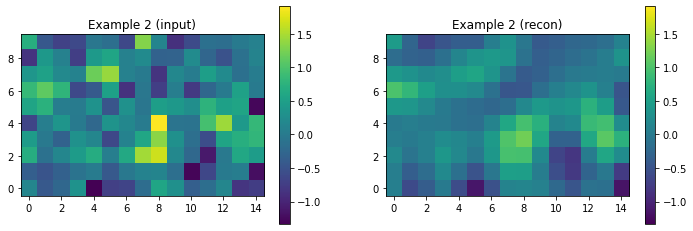

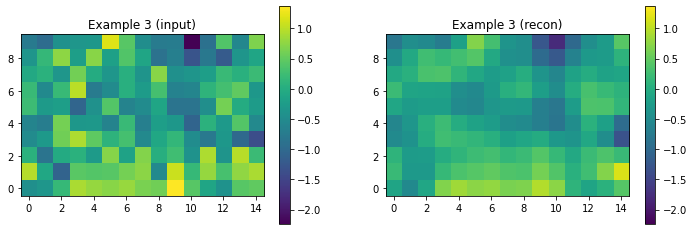

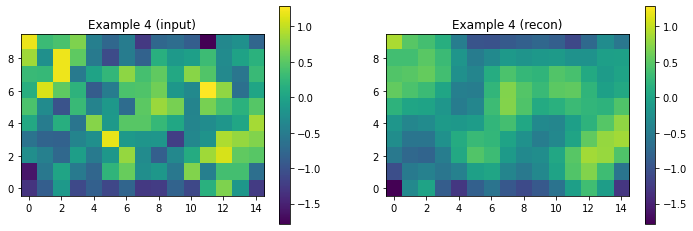

In [471]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    data_rng = jax.random.fold_in(rng_recon, i)
    # data_batch = generate_car_batch(data_rng, batch_size=ARGS.batch_size)
    data_batch = batched_val_data[i]
    outputs = net.apply(params, RNG_KEY, data_batch)
    out = outputs.output

    example_image = jnp.ravel(data_batch[0])
    recon_image = jnp.ravel(out[0])

    _, ax, _ = plotting.plot_images_from_arrays(
        arrays=[example_image, recon_image],
        titles=['input', 'recon'],
        image_shape=IMAGE_SHAPE,
        # custom_min=-0.1,
        # custom_max=0.1,
    )
    
    ax[0].set_title(f'Example {i} (input)')
    ax[1].set_title(f'Example {i} (recon)')

SAVE THIS MODEL

In [472]:
params.keys()

dict_keys(['prior_vae/decoder_hidden', 'prior_vae/linear', 'prior_vae/log_std', 'prior_vae/mean', 'prior_vae/output'])

In [473]:
decoder_params = {
  'decoder_hidden': params['prior_vae/decoder_hidden'],
  'output': params['prior_vae/output'],
}
CAR_ARGS.decoder_params = decoder_params

decoder_net = hk.without_apply_rng(hk.transform(
  lambda z: priorvae_decoder(z, 
                             hidden_dim=ARGS.hidden_dim, 
                             output_dim=ARGS.output_dim))
)

In [474]:
from pathlib import Path

model_name = (
  f'priorVAE_CAR_'
  f'h{ARGS.hidden_dim}l{ARGS.latent_dim}_' 
  f'lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
  f'batchSize{ARGS.batch_size}'
)
print(model_name)

model_path = Path('./models/priorVAE') / model_name
print(model_path)

priorVAE_CAR_h130l50_lr0.001_epochs10000_batchSize100
models/priorVAE/priorVAE_CAR_h130l50_lr0.001_epochs10000_batchSize100


In [475]:
from model import save_params

SAVE_MODEL = True

if SAVE_MODEL:
    model_path.mkdir(exist_ok=True, parents=True)
    save_params(model_path, params)
    print(f'Saved to path: {model_path}')

Saved to path: models/priorVAE/priorVAE_CAR_h130l50_lr0.001_epochs10000_batchSize100


In [476]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


In [477]:
def vae_predictive_model(args: CARArgs, 
                       y: Optional[jnp.ndarray] = None, 
                       noise: Optional[jnp.ndarray] = None) -> None:
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    
    out = jnp.ravel(decoder_net.apply(args.decoder_params, z))
    
    car_vae = numpyro.deterministic('car_vae', out)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car_vae, noise), obs=y)

In [478]:
vae_preds = Predictive(vae_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
vae_draws = vae_preds['car_vae']

car_preds = Predictive(car_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

assert vae_draws.shape == car_draws.shape, 'vae_draws dimensions do not match car_draws dimensions'

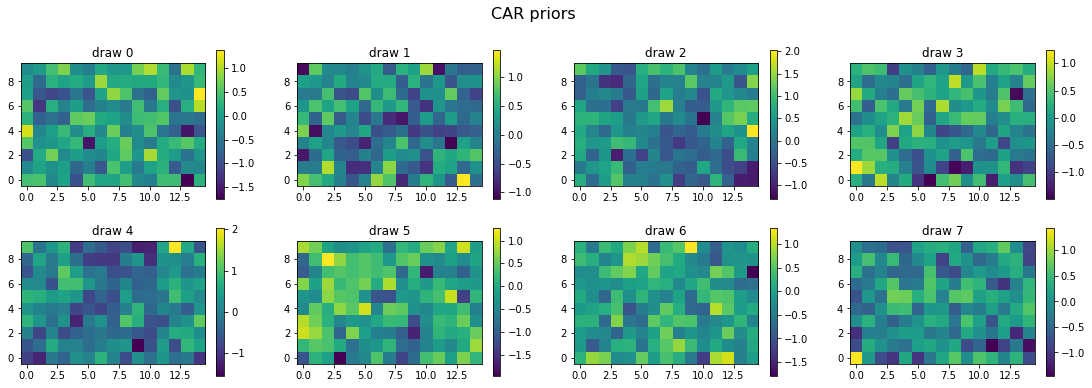

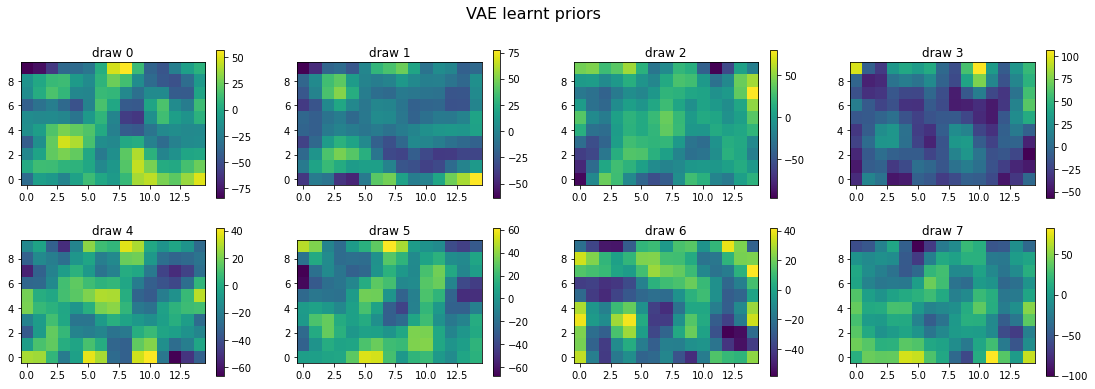

Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


In [479]:
plotting.plot_samples(car_draws, rows=2, figsize=(19, 6), image_shape=IMAGE_SHAPE)
plotting.plot_samples(vae_draws, rows=2, figsize=(19, 6), title=f'VAE learnt priors', image_shape=IMAGE_SHAPE)
print(ARGS)

In [480]:
# plotting.plot_samples(vae_draws, rows=2, figsize=(19, 6), title=f'VAE learnt priors', image_shape=IMAGE_SHAPE, custom_min=-0.2, custom_max=0.2)

Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


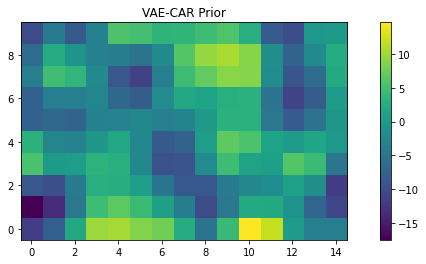

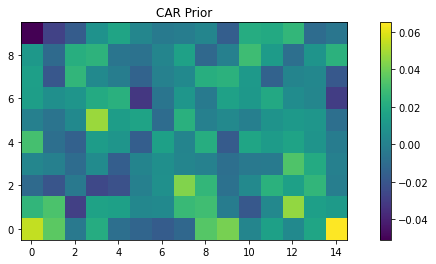

In [481]:
# VAE-CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_samples = 1000
car_draws = Predictive(car_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car']
vae_draws = Predictive(vae_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car_vae']

mean_prior_pred_vae = np.mean(vae_draws, axis=0)
hpdi_prior_pred_vae = hpdi(vae_draws, 0.89)
mean_prior_pred_car = np.mean(car_draws, axis=0)
hpdi_prior_pred_car = hpdi(car_draws, 0.89)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_vae],
    titles=['VAE-CAR Prior'],
    image_shape=IMAGE_SHAPE,
)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_car],
    titles=['CAR Prior'],
    image_shape=IMAGE_SHAPE,
);

In [482]:
def car_predictive_model_with_noise(
    args: CARArgs, y=None, alpha=None, noise=None) -> None:
    A = args.adj_matrix
    D = jnp.diag(args.degree_vector)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha*A)
    
    car = numpyro.sample(
        'car', dist.MultivariateNormal(
            loc=jnp.zeros(num_regions), precision_matrix=Q))
    numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car, noise), obs=y)

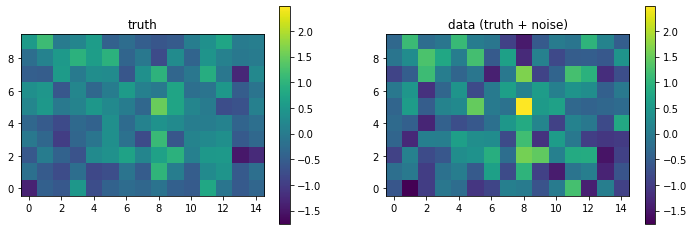

In [483]:
# Generate ground truth - fix alpha
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_predictive = Predictive(car_predictive_model_with_noise, num_samples=1)
car_preds = car_predictive(rng_pred, CAR_ARGS, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data],
    titles=['truth', 'data (truth + noise)'],
    image_shape=IMAGE_SHAPE
);

In [484]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference time
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(vae_predictive_model, init_strategy=init_strategy)
mcmc = MCMC(
    kernel,
    num_warmup=2000, 
    num_samples=2000,
)
mcmc.run(rng_mcmc, CAR_ARGS, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1020.19it/s, 15 steps of size 3.49e-01. acc. prob=0.92]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  car_vae[0]     -0.82      0.69     -0.85     -1.90      0.39   3929.68      1.00
  car_vae[1]     -1.31      0.51     -1.31     -2.13     -0.50   4045.50      1.00
  car_vae[2]     -1.11      0.53     -1.13     -1.97     -0.27   4763.34      1.00
  car_vae[3]     -0.42      0.52     -0.41     -1.23      0.48   3808.16      1.00
  car_vae[4]     -0.23      0.53     -0.23     -1.16      0.61   3581.14      1.00
  car_vae[5]     -0.80      0.53     -0.80     -1.67      0.08   4988.31      1.00
  car_vae[6]     -0.81      0.52     -0.83     -1.64      0.01   4522.95      1.00
  car_vae[7]     -0.15      0.51     -0.15     -0.94      0.71   4416.54      1.00
  car_vae[8]     -0.10      0.54     -0.08     -0.95      0.82   3684.50      1.00
  car_vae[9]     -0.71      0.53     -0.71     -1.63      0.10   4186.74      1.00
 car_vae[10]     -0.48      0.54     -0.47     -1.35      0.38   4668.82      1.00
 ca

In [485]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car_vae']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 5 s
Average ESS for all CAR effects : 4473


Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


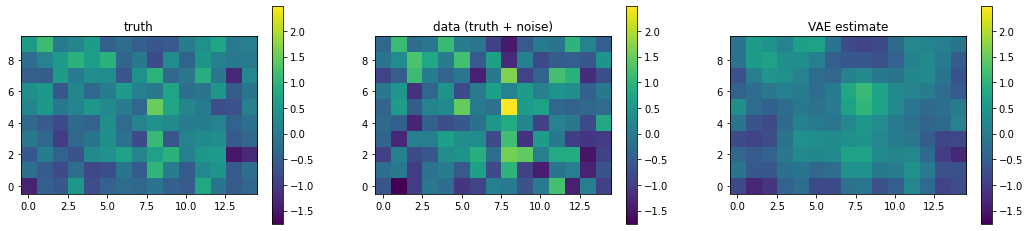

In [486]:
# Posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

posterior_predictions = Predictive(vae_predictive_model, mcmc_samples)(rng_pred, CAR_ARGS)
post_obs = posterior_predictions['car_vae']

mean_post_pred_vae = np.mean(post_obs, axis=0)
bci_vae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_vae],
    titles=['truth', 'data (truth + noise)', 'VAE estimate'],
    figsize=(18, 4),
    image_shape=IMAGE_SHAPE,
);

In [487]:
mse_vae = np.mean((y_truth - mean_post_pred_vae)**2).item()
print(f'{mse_vae = }')

mse_vae = 0.22124390304088593


In [488]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x168725ca0>, batch_size=100, hidden_dim=130, latent_dim=50, output_dim=150, beta=1.0, learning_rate=0.001, epochs=10000, eval_frequency=10)


In [489]:
# 0.239 hidden 110 latent 110 epochs 20k
# 0.211 hidden 130 latent 120 epochs 20k
# 0.233 hidden 132 latent 132 epochs 20k